# Allocation Strategy Analysis

Use this notebook to run allocation strategies on available equity data.

Download historical stock prices from the following:
- https://www.kaggle.com/ehallmar/daily-historical-stock-prices-1970-2018

S&P500 weights obtained from: https://www.slickcharts.com/sp500 (04/07/2021)

In [2]:
# Analysis
import pandas as pd
import numpy  as np
import cvxpy  as cp
import sklearn
from   sklearn.decomposition import PCA

# Data import
import zipfile

# Visualization
import matplotlib.pyplot as plt

# Misc
from datetime import datetime as dtime, timedelta as tdelta
import os

pd.options.mode.chained_assignment = None  # default='warn'

### Unzip

In [3]:
full_path = os.getcwd()

In [ ]:
# Extract stock prices from zip
zip_ref = zipfile.ZipFile(full_path + "/archive.zip", 'r')
zip_ref.extractall(full_path + "/data")
zip_ref.close()

### Cleaning + Creating Historical Stock Prices Dataframe

In [4]:
stock_prices_df  = pd.read_csv(
    full_path    + "/data/historical_stock_prices.csv",
    parse_dates  = ["date"],
    usecols      = ["date", "ticker", "adj_close"]
)

sp_500           = pd.read_csv(full_path + "/data/sp500.csv")
sp_500["weight"] = sp_500["weight"] / sp_500["weight"].sum()

In [6]:
# ==============
# Filter by date
# ==============
START_DATE_FILTER = dtime(2005,  1,  1)
END_DATE_FILTER   = dtime(2017, 12, 31)
stock_prices_df   = stock_prices_df[
    (stock_prices_df.date >= START_DATE_FILTER) &
    (stock_prices_df.date <=   END_DATE_FILTER)
]

# ==============
# Filter to only include tickers that are present throughout the entire date range
# ~1926 tickers satisfy this criteria
# ==============
total_dates       = len(stock_prices_df.date.unique())
stock_appearances = stock_prices_df.ticker.value_counts()
filtered_stock    = pd.DataFrame(
    data = {"ticker": stock_appearances[stock_appearances == total_dates].index}
)

stock_prices_df   = pd.merge(stock_prices_df, filtered_stock, on="ticker", how="inner")

### Raw Prices & Percentage Returns Dataframes

In [140]:
raw_prices  = stock_prices_df.pivot_table(index="date", columns=["ticker"], values="adj_close")
raw_prices  = raw_prices.drop(columns=["GOOGL"])
pct_returns = raw_prices.pct_change().dropna()

In [141]:
pct_14d_returns = pct_returns.resample("14D").sum()

In [142]:
universe_tickers = pct_returns.columns

### Cleaning and filtering into S&P500 stocks (~391 resulting tickers)

In [ ]:
# Additionally filter by stocks contained within the S&P500
#
# 391 tickers satisfy this criteria
#
#filtered_df = stock_prices_df.merge(sp_500, on="ticker", how="inner")
#filtered_df = filtered_df.drop("weight", axis=1)
#filtered_df = filtered_df.pivot_table(index="date", columns=["ticker"], values="adj_close")

### Calculate log performance

In [ ]:
#stock_performances = {}
#
#for ticker in filtered_df.ticker.unique():
#    temp                   = filtered_df[filtered_df.ticker == ticker]
#    temp["ln_adj_close_1"] = np.log(temp.adj_close)
#    temp["ln_adj_close_2"] = temp.ln_adj_close_1.shift(-1)
#    temp["ln_return"]      = temp.ln_adj_close_2 - temp.ln_adj_close_1
#    temp                   = temp.drop(["ln_adj_close_1", "ln_adj_close_2"], axis=1)
#    stock_performances[ticker] = temp

In [ ]:
#final_df = pd.DataFrame()
#
#for k, v in stock_performances.items():
#    final_df = final_df.append(v)
#    
#final_df = final_df.fillna(0)
#final_df = final_df.set_index("date")

In [ ]:
#stock_ln_returns = final_df.pivot_table(index="date", columns="ticker", values="ln_return")

In [ ]:
#ticker_order = stock_ln_returns.columns.tolist()

#### Statistical Calculations

Calculate covariance matrix ($\Sigma$) and inverse covariance matrix ($\Sigma^{-1}$) on stock log returns

Calculate volatility ($\sigma$) on stock log returns

In [10]:
#def get_cov_ln_returns(tickers, start_date, end_date):
#    tickers = list(set(stock_ln_returns.columns).intersection(tickers))
#    
#    return stock_ln_returns[tickers][(start_date <= stock_ln_returns.index) & \
#                            (stock_ln_returns.index <= end_date)].cov()
#
#def get_std_ln_returns(tickers, start_date, end_date):
#    tickers = list(set(stock_ln_returns.columns).intersection(tickers))
#    
#    return stock_ln_returns[tickers][(start_date <= stock_ln_returns.index) & \
#                            (stock_ln_returns.index <= end_date)].std()

def get_cov_pct_returns(tickers, start_date, end_date):
    tickers  = list(set(pct_returns.columns).intersection(tickers))
    filtered = pct_14d_returns[tickers][(start_date <= pct_14d_returns.index) & (pct_14d_returns.index <= end_date)]
    
    return (filtered - filtered.mean()).cov()

def get_std_pct_returns(tickers, start_date, end_date):
    tickers = list(set(pct_returns.columns).intersection(tickers))
    
    return pct_14d_returns[tickers][(start_date <= pct_14d_returns.index) & (pct_14d_returns.index <= end_date)].std()

In [232]:
get_std_pct_returns(['GOOG', 'AAPL', 'MSFT', 'C', 'GS'], dtime(2010, 1, 4), dtime(2010, 2, 25))

ticker
GOOG    0.062670
AAPL    0.061515
MSFT    0.041053
GS      0.079105
C       0.088166
dtype: float64

#### Testing CVXPY

In [12]:
w           = cp.Variable(3)
cov_mat     = np.random.rand(3, 3)
cov_mat     = cov_mat.T @ cov_mat
vol         = np.random.rand(3)

objective   = cp.Minimize(cp.quad_form(w, cov_mat))
constraints = [w.T @ vol == 1, w >= 0]
problem     = cp.Problem(objective, constraints)
problem.solve()

weights     = w.value

print(weights)

[ 1.87268046e+00 -3.05110003e-22 -8.60977169e-23]


### Uniform Weighting

Each stock is given a $1/N$ weight/allocation.

### Market Cap Weighting

Each stock is weighted according to their respective market cap (as of 2021). For simplicity, we assume that this market cap weighting has held since the beginning of the trading strategy. This will thus become overweight on stocks that have grown into large market cap, and may present over-optimistic portfolio performance.

In [316]:
def get_uniform_weights(tickers, start_date, end_date):
    date_range = pd.date_range(start_date, end_date)
    tickers    = list(set(sp_500.ticker).intersection(set(pct_returns.columns)))
    N          = len(tickers)
    
    ret_df = pd.DataFrame(
        index   = date_range,
        columns = tickers,
        data    = np.full((len(date_range), N), 1/N)
    )
    
    ret_df.index.name = "date"
    
    return ret_df

def get_market_cap_weights(start_date, end_date):
    date_range     = pd.date_range(start_date, end_date)
    ticker_weights = sp_500.pivot_table(columns="ticker", values="weight")
    tickers        = list(set(sp_500.ticker).intersection(set(pct_returns.columns)))
    weight_vec     = ticker_weights[tickers].values[0]
    shape          = (len(date_range), len(tickers))
    
    ret_df = pd.DataFrame(
        index   = date_range,
        columns = tickers,
        data    = np.tile(weight_vec, len(date_range)).reshape(shape)
    )
    
    ret_df.index.name = "date"
    
    return ret_df

### Maximum Diversification Weighting

Goal: Create portfolios that have minimally correlated assets, lower risk levels, and possibly higher returns.

(Introduced by Choueifaty and Coignard, 2008 and Pemberton & Rau, 2007)

The objective is to find the weight $w$ that maximizes the following:

$
\max_w \frac{w^T a}{\sqrt{w^T \Sigma w }}
$

We obtain the following short-selling allowed analytical solution:

$
w_{MD} = \frac{\Sigma^{-1} \sigma}{\sigma^T \Sigma^{-1} \sigma}
$

When restricting the weights to $w \geq 0$, we use `cvxpy` to solve the original convex optimization problem:

$
\min_w \frac{1}{2} w^T \Sigma w
$

s.t.
$
w^T \sigma = 1 \newline
w   \geq 0
$

In [288]:
def get_max_diverse_weights(tickers, start_date, end_date, rebalance_days):
    date_range  = pd.date_range(start_date, end_date)
    tickers     = list(set(universe_tickers).intersection(set(tickers)))
    ret_df      = pd.DataFrame(index = date_range, columns = tickers)
    
    # pct_returns_cov     = None
    # pct_returns_cov_inv = None
    # pct_returns_vol     = None
    max_diverse_weight  = None
    
    rebalance = False
    
    for date in date_range:
        
        if (date - start_date).days % rebalance_days == 0:
            pct_returns_cov     = get_cov_pct_returns(tickers, date + tdelta(days = -365), 
                                                      date + tdelta(days = -1)).values
            
            pct_returns_cov_inv = np.linalg.inv(pct_returns_cov)
            
            pct_returns_vol     = get_std_pct_returns(tickers, date + tdelta(days = -365), 
                                                      date + tdelta(days = -1)).values
            
            max_diverse_weight  = (pct_returns_cov_inv @ pct_returns_vol) / \
                                    (pct_returns_vol.T @ pct_returns_cov_inv @ pct_returns_vol)

        else: # No need to rebalance, just use previously calculated weights
            norm_factor         = np.sum(max_diverse_weight)
            max_diverse_weight  = max_diverse_weight / norm_factor
            ret_df.loc[date]    = max_diverse_weight
        
    return ret_df.dropna()

def get_max_diverse_long_only_weights(tickers, start_date, end_date, rebalance_days):
    date_range  = pd.date_range(start_date, end_date)
    tickers     = list(set(universe_tickers).intersection(set(tickers)))
    ret_df      = pd.DataFrame(index = date_range, columns = tickers)
    
    # Get weights from the respective convex optimization problem
    # min  w^T \Sigma w
    # s.t. w^T \sigma  = 1
    #      w          >= 0
    def get_weights(vol, cov_mat):
        w           = cp.Variable(len(vol))
        objective   = cp.Minimize(cp.quad_form(w, cov_mat))
        ones_vec    = np.ones(len(vol))
        constraints = [w >= 0, w.T @ ones_vec == 1]
        problem     = cp.Problem(objective, constraints)
        problem.solve()
        return w.value
    
    max_diverse_weight = None
    
    for date in date_range:
        
        if (date - start_date).days % rebalance_days == 0:
            pct_returns_cov     = get_cov_pct_returns(tickers, date + tdelta(days = -365), 
                                                      date + tdelta(days = -1)).values
            
            pct_returns_vol     = get_std_pct_returns(tickers, date + tdelta(days = -365),
                                                      date + tdelta(days = -1)).values
            
            # Solve the convex optimization problem each time
            max_diverse_weight  = get_weights(pct_returns_vol, pct_returns_cov)
            
        else: # No need to rebalance, just use previously calculated weights
            norm_factor         = np.sum(max_diverse_weight)
            max_diverse_weight  = max_diverse_weight / norm_factor
            ret_df.loc[date]    = max_diverse_weight
            
    return ret_df.dropna()

### Global Minimum Variance

The GMV portfolio is the lowest risk portfolio on the efficient frontier.

It solves the following optimization problem:

$
min_w w^T \Sigma w
$

s.t. $w^T 1 = 1$

The analytical solution is as follows:

$w^* = \frac{\Sigma^{-1} 1} {1^T \Sigma^{-1} 1}$

In [233]:
def get_gmv_weights(tickers, start_date, end_date, rebalance_days):
    date_range  = pd.date_range(start_date, end_date)
    tickers     = list(set(universe_tickers).intersection(set(tickers)))
    ret_df      = pd.DataFrame(index = date_range, columns = tickers)
    gmv_weight  = None
    
    for date in date_range:
        if (date - start_date).days % rebalance_days == 0:
            pct_returns_cov     = get_cov_pct_returns(tickers, date + tdelta(days = -365), date + tdelta(days = -1)).values      
            pct_returns_cov_inv = np.linalg.inv(pct_returns_cov)
            ones_vec            = np.ones(len(tickers))
            gmv_weight          = pct_returns_cov_inv @ ones_vec / (ones_vec.T @ pct_returns_cov_inv @ ones_vec)
        else: # No need to rebalance, just use previously calculated weights
            ret_df.loc[date]    = gmv_weight
            
    return ret_df.dropna()

### Statistical Factor Model (In-progress)

At a specific time $t$ for which the portfolio is to be rebalanced, for each asset $k$, we try to find the asset's exposure to each factor via OLS:

$
R_k(t) = \alpha_k + \sum_i^{n} \beta_{ki} f_i(t) = \alpha_k + \beta_{k1} f_1 + \beta_{k2} f_2 + ... + \beta_{kn} f_n
$

We will estimate the coefficients $\beta_{ki} \forall i$ for a given asset $k$.

In [414]:
def get_factor_analysis_weights(tickers, start_date, end_date, rebalance_days, num_factors: int = 5):
    date_range = pd.date_range(start_date, end_date)
    tickers    = list(set(universe_tickers).intersection(set(tickers)))
    ret_df     = pd.DataFrame(index = date_range, columns = tickers)
    fa_weight  = None
    
    filtered_pct_returns = pct_returns[tickers]
    
    for date in date_range:
        if (date - start_date).days % rebalance_days == 0:
            
            pca = PCA(n_components = num_factors)
            pca.fit(filtered_pct_returns)

            # Each column vector / eigenvector is a factor loading
            eigenvecs         = pca.components_.T
            factor_loadings   = pca.components_.T

            # Apply dimensionality reduction
            factor_returns = pca.fit_transform(filtered_pct_returns)
            cov_factor     = np.cov(np.transpose(factor_returns))
            mu             = pca.mean_

            # Constructing the matrix D
            reconstructed_returns = factor_returns @ factor_loadings.T + mu.T
            unexplained_returns   = filtered_pct_returns - reconstructed_returns
            unexplained_variance  = np.diag(np.cov(unexplained_returns.T))
            D                     = np.diag(unexplained_variance)

            w  = cp.Variable(len(filtered_pct_returns.columns)) # weight
            fw = cp.Variable(num_factors) # factor weight
            e  = np.ones(len(filtered_pct_returns.columns))

            target_risk = 0.010

            # Solve convex optimization problem 
            # =================================
            # Details here: https://www.mathworks.com/help/finance/portfolio-optimization-using-factor-models.html
            objective   = cp.Maximize(mu.T @ w)
            constraints = [
                cp.quad_form(fw, cov_factor) + cp.quad_form(w, D) <= target_risk,
                w.T @ e == 1,
                factor_loadings.T @ w == fw,
                w >= 0
            ]

            prob = cp.Problem(objective, constraints)
            prob.solve()
            
            # Recalibrate weight on rebalance day
            fa_weight = w.value
        
        else: # No need to rebalance, just use previously calculated weights
            ret_df.loc[date] = fa_weight
            
    return ret_df.dropna()

### Strategy Execution / Performance Code

In [379]:
# Input arguments
# ===============
# weight_function: *Function* with the following (possibly optional) inputs:
#                     - current stocks / tickers
#                     - datetime
#                  and outputs a *Dictionary* of weights corresponding to the allocation at that time
# start_date:      When to start the allocation strategy
# end_date:        When to end the allocation strategy
#
# Returns an np.array of wealth for the dates falling within the start_date and end_date 
def execute_strategy(df, weight_function, start_date, end_date):
    date_range = pd.date_range(start_date, end_date)
    
    valid_dates, log_perfs = np.array([]), np.array([])
    
    for date_time in date_range:
        
        # May be the case on a weekend, holiday, or other non-trading data
        if date_time not in df.index: 
            continue
            
        valid_dates = np.append(valid_dates, date_time)
            
        # Dynamic calculation of weights
        tickers     = np.array(df.loc[date_time].ticker)
        weights     = weight_function(tickers = tickers, date_time = date_time)
        weight_df   = pd.DataFrame(data = weights).set_index("ticker")
        
        current_day_df = df.loc[date_time]
        current_day_df = pd.merge(current_day_df, weight_df, how='left', on='ticker')

        log_perf    = np.sum(current_day_df.weight * current_day_df.ln_return)
        log_perfs   = np.append(log_perfs, log_perf)
            
    return valid_dates, log_perfs

def execute_strategy_v2(weights):
    daily_returns               = (pct_returns[weights.columns] * weights).dropna()
    daily_portfolio_pct_returns = daily_returns.sum(axis=1)
    return daily_portfolio_pct_returns, np.cumprod(daily_portfolio_pct_returns + 1)

### Uniform Weighting

In [380]:
unif_weights   = get_uniform_weights(
    tickers    = sp_500.ticker[-15:],
    start_date = dtime(2007, 1, 1), 
    end_date   = dtime(2017, 12, 31)
)

unif_daily_perf, unif_cumulative_perf = execute_strategy_v2(unif_weights)

### SP&500 Weighting

In [381]:
sp500_weights  = get_market_cap_weights(
    start_date = dtime(2007, 1, 1),
    end_date   = dtime(2017, 12, 31)
)

sp500_daily_perf, sp500_cumulative_perf = execute_strategy_v2(sp500_weights)

### Maximum Diversification Weighting

#### Short-selling Allowed

In [392]:
max_diverse_weights = get_max_diverse_weights(
    tickers        = list(sp_500.ticker[-15:]),
    start_date     = dtime(2007, 1, 1),
    end_date       = dtime(2017, 12, 31),
    rebalance_days = 90 # Rebalance every quarter
)

max_diverse_daily_perf, max_diverse_cumulative_perf = execute_strategy_v2(max_diverse_weights)

#### Short-selling Not Allowed (Long-only)

In [391]:
max_diverse_long_only_weights = get_max_diverse_long_only_weights(
    tickers        = list(sp_500.ticker[-15:]),
    start_date     = dtime(2007, 1, 1),
    end_date       = dtime(2017, 12, 31),
    rebalance_days = 90 # Rebalance every quarter
)

max_diverse_long_only_daily_perf, max_diverse_long_only_cumulative_perf = execute_strategy_v2(max_diverse_long_only_weights)

### Efficient-Frontier Weights

#### Global Minimum Variance (GMV)

In [413]:
gmv_weights = get_gmv_weights(
    tickers        = list(sp_500.ticker[-15:]),
    start_date     = dtime(2007, 1, 1),
    end_date       = dtime(2017, 12, 31),
    rebalance_days = 90 # Rebalance every quarter
)

gmv_daily_perf, gmv_cumulative_perf = execute_strategy_v2(gmv_weights)

### Factor Model Weighting

In [425]:
fa_weights = get_factor_analysis_weights(
    tickers        = list(sp_500.ticker[-15:]),
    start_date     = dtime(2007, 1, 1),
    end_date       = dtime(2017, 12, 31),
    rebalance_days = 90 # Rebalance every quarter
)

fa_daily_perf, fa_cumulative_perf = execute_strategy_v2(fa_weights)

### Performance Analysis & Visualization

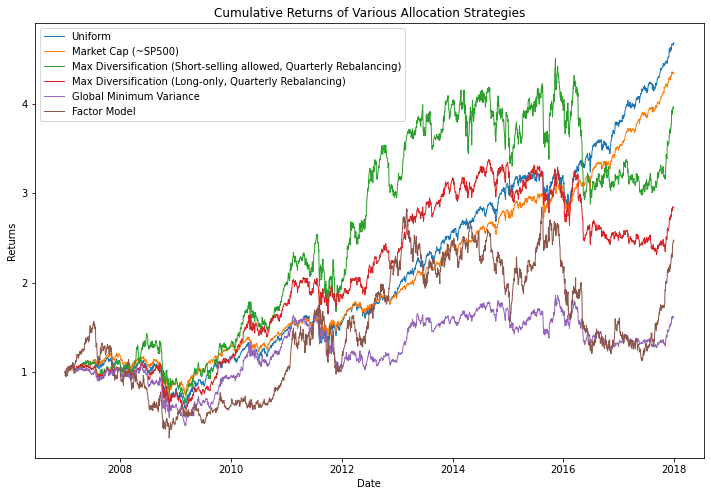

In [426]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(unif_cumulative_perf,                  linewidth=1.0, label="Uniform")
ax.plot(sp500_cumulative_perf,                 linewidth=1.0, label="Market Cap (~SP500)")
ax.plot(max_diverse_cumulative_perf,           linewidth=1.0, label="Max Diversification (Short-selling allowed, Quarterly Rebalancing)")
ax.plot(max_diverse_long_only_cumulative_perf, linewidth=1.0, label="Max Diversification (Long-only, Quarterly Rebalancing)")
ax.plot(gmv_cumulative_perf,                   linewidth=1.0, label="Global Minimum Variance")
ax.plot(fa_cumulative_perf,                    linewidth=1.0, label="Factor Model")

ax.set_title("Cumulative Returns of Various Allocation Strategies")
ax.set_xlabel("Date")
ax.set_ylabel("Returns")
ax.legend()
plt.show()